In [2]:
!pip install PyDrive
!pip install pyLDAvis
!pip install clean-text

     |████████████████████████████████| 1.7MB 8.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.0-py2.py3-none-any.whl size=136694 sha256=388e4539dfcd05563060e3a158d880055f5cf81cf6225e01feded8d005d36b34
  Stored in directory: /root/.cache/pip/wheels/5e/62/9d/e2d11b7e09f85508b7be451fa35a2bce4b12c66c10b8bcb182
Successfully built pyLDAvis
     |████████████████████████████████| 133kB 8.4MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-cp36-none-any.whl size=46451 sha256=225f469b181caed650682317447a3883278c767c0b2925491f5983dbeacaad7d
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ftfy


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import json
import plotly.express as px
import numpy as np

import pickle
import gensim
import pyLDAvis
import pyLDAvis.gensim
import spacy
import nltk; nltk.download('stopwords')
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from cleantext import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':'1aStKl8Fat_62rafpKfFUrnpSp3OvfV-g'}) 
downloaded.GetContentFile('Video_Games_5.json')  

# 1HASrSkq4_6CspaTcCgqLJEJxn1OLcHfr 2M review id

In [7]:
file = open('Video_Games_5.json', 'r', encoding='utf-8')
data_review = []
for line in file.readlines():
    dic = json.loads(line)
    data_review.append(dic)

print(len(data_review))

497577


In [8]:
data_review[0:2]

[{'asin': '0700026657',
  'overall': 5.0,
  'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.",
  'reviewTime': '10 17, 2015',
  'reviewerID': 'A1HP7NVNPFMA4N',
  'reviewerName': 'Ambrosia075',
  'summary': "but when you do it's great.",
  'unixReviewTime': 1445040000,
  'verified': True},
 {'asin': '0700026657',
  'overall': 4.0,
  'reviewText': 'I played it a while but it was alright. The steam was a bit of trouble. The more they move these game to steam the more of a hard time I have activating and playing a game. But in spite of that it was fun, I liked it. Now I am looking forward to anno 2205 I really want to play my way to the moon.',
  'reviewTime': '07 27, 2015',
  'reviewerID': 'A1JGAP0185YJI6',
  'reviewerName': 'travis',
  'summary': 'But in spite of that it was fun, I liked it',
  'unixReviewTime': 1437955200,
  'verified': False}]

In [9]:
df_review = pd.DataFrame(data_review)

In [10]:
df_review.sample(10)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
41935,5.0,False,"09 1, 2003",A34GR92HWDALSP,B000084318,Carlos,this game is one of gamecube's must buy\nsound...,this game is great,1062374400,NaN,{'Format:': ' Video Game'},NaN
38179,4.0,True,"01 26, 2003",A2402NCEJQ50JI,B00006IJIU,Jeff Schmidt,I previously owned NBA Inside Drive 2002. It ...,A big improvement!,1043539200,3,NaN,NaN
325851,4.0,True,"06 29, 2014",AVGZZIUZWPE67,B00ET6LPJ6,Jaron,I like it. Graphics are great and there's a l...,Fun game!,1404000000,NaN,{'Platform:': ' Mac Download'},NaN
484843,5.0,False,"07 7, 2012",A8INT3NMHRUS4,B0073ESZDK,Kim Karas,This is a nice clear cover that protects 3DS f...,Good looking protection,1341619200,NaN,NaN,NaN
325302,5.0,True,"09 23, 2016",A3ECIQQ2W0N6X6,B00EO6GSY8,Yun L.,Did its job as expected,Five Stars,1474588800,NaN,NaN,NaN
297777,4.0,True,"07 12, 2013",AOHNLSWSOLK8N,B00BZOBE78,Knightwind,Second update on the review of Brave New World...,"Wow, this ALMOST makes Civ V SWEET! (changing...",1373587200,5,{'Platform:': ' PC'},NaN
165975,5.0,True,"05 8, 2015",A2REDX45XY28EI,B001A4MTGS,Amazon Customer,it was great i like the game,it was great i like the,1431043200,NaN,{'Format:': ' Video Game'},NaN
464256,5.0,True,"04 28, 2008",A26OPMU8YTWVOM,B000FLWCLY,M. Fields,"I bought three packages of these, and put them...",DS Must Have,1209340800,3,NaN,NaN
83931,5.0,True,"08 15, 2017",A23URGQV3AOPOK,B000FQ9R4E,Butterfly smurf,gave as a gift kids say they like it,Christmas stocking stuffer,1502755200,NaN,NaN,NaN
49766,5.0,True,"06 25, 2014",AQ46HO28ZVEL3,B0000A92KX,Jason L . Inocencio,great game,Five Stars,1403654400,NaN,{'Format:': ' Video Game'},NaN


In [11]:
df_review = df_review.sample(50000)

In [12]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 56546 to 98839
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         50000 non-null  float64
 1   verified        50000 non-null  bool   
 2   reviewTime      50000 non-null  object 
 3   reviewerID      50000 non-null  object 
 4   asin            50000 non-null  object 
 5   reviewerName    49988 non-null  object 
 6   reviewText      49980 non-null  object 
 7   summary         49994 non-null  object 
 8   unixReviewTime  50000 non-null  int64  
 9   vote            10911 non-null  object 
 10  style           29105 non-null  object 
 11  image           358 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 4.6+ MB


In [13]:
df_review.shape

(50000, 12)

In [14]:
df_review.isnull().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName         12
reviewText           20
summary               6
unixReviewTime        0
vote              39089
style             20895
image             49642
dtype: int64

In [15]:
df_review['vote'] = df_review['vote'].fillna(0)

In [16]:
df_review.isnull().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
reviewerName         12
reviewText           20
summary               6
unixReviewTime        0
vote                  0
style             20895
image             49642
dtype: int64

In [17]:
# convert column vote to numeric value
df_review['vote'] = df_review['vote'].str.replace(',','')
df_review['vote'] = pd.to_numeric(df_review['vote'])

In [22]:
df_vote_range = df_review.loc[df_review['vote']>100]

In [23]:
# create bins starting with 0 up to 6K
bins = np.linspace(0, 5500, 11)

# use pd.cut to create the bins. In order to include zero, `include_lowest` is set to True
df_vote_range['range'] = pd.cut(df_vote_range['vote'], bins, include_lowest=True)

# pd.cut creates an interval category which is sorted from lowest bin to the greatest bin
df_vote_range['range'].cat.categories


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



IntervalIndex([(-0.001, 550.0], (550.0, 1100.0], (1100.0, 1650.0], (1650.0, 2200.0], (2200.0, 2750.0], (2750.0, 3300.0], (3300.0, 3850.0], (3850.0, 4400.0], (4400.0, 4950.0], (4950.0, 5500.0]],
              closed='right',
              dtype='interval[float64]')

In [24]:
# count the values in each bin. Bins are sorted based on the occurance (from most populated to the least one)
agg = df_vote_range['range'].value_counts()

# sort the values according to the bins (`sort_index`), turn into data frame (`to_frame`) and reset index
agg = agg.sort_index().to_frame().reset_index()

# rename index (containing the bin range e.g. "(5000000.0, 10000000.0]" to bins)
agg.rename(columns={'index':'bins'}, inplace=True)

# Plotly cannot work with categories index, so we need to turn it into string
agg['bins'] = agg['bins'].astype("str")


In [25]:
#fig = px.histogram(df_remove_zero_vote, x='vote', nbins=500)
#fig.show()

fig = px.bar(agg, x='bins', y='range', text='range',
       title='Count of Vote above 100', 
       labels={'range':'count'})
fig.show()

In [26]:
fig = px.histogram(df_vote_range, x='vote', nbins=500)
fig.show()

In [27]:
len(df_review['reviewerID'].unique())

30374

In [28]:
df_reviewer = df_review.groupby(['reviewerID']).agg({'reviewText':'count','vote':'sum'})
df_reviewer['ratio'] = df_reviewer['reviewText']/df_reviewer['vote']

In [29]:
len(df_reviewer['ratio'].unique())

476

In [30]:
df_reviewer['ratio'].replace(np.inf, 0, inplace=True)
df_reviewer.sample(10)

,reviewText,vote,ratio
reviewerID,,,
ANMPFSIJE5N5O,3,0.0,0.000000
A7SQPYLWXOSKR,1,0.0,0.000000
A1O7C0RN447LIH,2,8.0,0.250000
A3Q5OISFM2FTT1,1,0.0,0.000000
A1UYK6MPGB4KX3,1,0.0,0.000000
A3AFI1MI0EWX3I,2,35.0,0.057143
A1SNUJDSSOQ1JV,1,0.0,0.000000
A2EDMJSIH8ZUIT,2,0.0,0.000000
A31ZDP90HIKFOT,1,0.0,0.000000


In [31]:
df_review = pd.merge(df_review,  
                      df_reviewer,  
                      on ='reviewerID',  
                      how ='inner') 
df_review

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText_x,summary,unixReviewTime,vote_x,style,image,reviewText_y,vote_y,ratio
0,5.0,False,"07 26, 2006",A1ILEVGCZXRTC7,B00026D13A,M. DiSpirito,The Movies - for better or worse - is a marvel...,What a Phenom!,1153872000,10.0,{'Platform:': ' PC'},NaN,8,41.0,0.195122
1,5.0,False,"02 27, 2006",A1ILEVGCZXRTC7,B0000A2TPE,M. DiSpirito,What an astounding game! For all the negativi...,How much FUN is this!,1140998400,6.0,NaN,NaN,8,41.0,0.195122
2,4.0,False,"02 28, 2006",A1ILEVGCZXRTC7,B00026ENLE,M. DiSpirito,Up-front: this game is not ground-breaking or ...,Fun Addition to Fantasy Strategy,1141084800,NaN,{'Platform:': ' PC'},NaN,8,41.0,0.195122
3,3.0,False,"04 10, 2006",A1ILEVGCZXRTC7,B00004Y7ZO,M. DiSpirito,Ski Resort Tycoon is exactly what the name imp...,Dated but Decent sim game,1144627200,2.0,NaN,NaN,8,41.0,0.195122
4,2.0,False,"03 2, 2006",A1ILEVGCZXRTC7,B0002ML7M6,M. DiSpirito,Reading the Title one may wonder why I bothere...,Elemental Failure is more like it...,1141257600,10.0,NaN,NaN,8,41.0,0.195122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5.0,True,"10 18, 2016",A1C20VH273TSC7,B001NX4DUQ,Emre H. Ulkucu,"Yeah, it's a total rip-off of God of War III.....",A God of War Rip-off that is MORE fun?!,1476748800,NaN,{'Platform:': ' Xbox 360'},NaN,1,0.0,0.000000
49996,5.0,True,"12 18, 2015",A3IC46QHBMPKJB,B00XR3YC2E,Devin D. Bass,this Is a very good expansion pack. A lot of p...,this Is a very good expansion pack,1450396800,NaN,"{'Edition:': ' Rising Tide', 'Platform:': ' PC'}",NaN,1,0.0,0.000000
49997,5.0,True,"05 16, 2015",A3VHUAIQN4JLSJ,B006JKASCK,SANDRO,Awesome!!!,Five Stars,1431734400,NaN,{'Edition:': ' 32 GB'},NaN,1,0.0,0.000000
49998,1.0,True,"07 14, 2014",A2Z6141TNBUKOY,B00EZAWV6W,carolyn osterkamp,i bought this game for my PC and have tried ev...,plants vs zombies garden warfare.,1405296000,NaN,{'Platform:': ' PC Download'},NaN,1,0.0,0.000000


In [32]:
df_review['ratio'].mean()

0.21336693808604332

In [55]:

# create a list of our conditions
conditions = [(df_review['ratio'] <= df_review['ratio'].mean()), (df_review['ratio'] > df_review['ratio'].mean())]

# create a list of the values we want to assign for each condition
values = [0, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
df_review['helpful'] = np.select(conditions, values)


In [56]:
# display updated DataFrame
df_review.sample(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,ratio,helpful
31086,2.0,True,"01 6, 2015",AW0IOR4AEEK46,B007FTE2VW,CindyWard,Ran very slow on my PC...not what I expected.,Two Stars,1420502400,2.0,{'Format:': ' Software Download'},NaN,0.5,1
44857,3.0,True,"03 13, 2015",A365W7MZJSU9GI,B00EFRN2IQ,WatersMK,not worth 60.00 bucks but got on sale for 30.0...,if you like the other sims games this is mainl...,1426204800,2.0,"{'Edition:': ' Standard', 'Platform:': ' PC / ...",NaN,0.5,1
6245,5.0,True,"01 26, 2015",ABDGHADGJKJC2,B0050SWZHS,Richard Pereira,excelente,Five Stars,1422230400,NaN,{'Format:': ' Video Game'},NaN,0.0,0
31137,5.0,True,"03 2, 2018",A2Y2BFV0TJYLPH,B000S1MMIE,Jed A. Hirsch,Thank you,Five Stars,1519948800,NaN,{'Platform:': ' Xbox 360'},NaN,0.0,0
49557,4.0,False,"11 16, 2006",A1RJ7QZKBRQN1M,B000FRS9II,f9_Market,This had been my most anticipated game when th...,Impressive....,1163635200,2.0,{'Format:': ' Video Game'},NaN,0.5,1


In [ ]:
df_review = df_review.drop(columns=['reviewText_y', 'vote_y'], axis=1)

In [58]:
df_review.rename(columns={'reviewText_x':'reviewText', 'vote_x':'vote'}, inplace=True)
df_review.sample(5)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,ratio,helpful
44805,5.0,False,"11 23, 2002",A24FRZ6ZJIGMC0,B00006JZQZ,Amazon Customer,I'm probably a tad older than some of the game...,Wow.,1038009600,NaN,{'Platform:': ' Xbox'},NaN,0.0,0
44246,5.0,True,"04 18, 2014",A2BOGWVZ40AKPO,B00EZPCX1A,BellaNoche,Bought this for my daughters 11th bday. We own...,So far so good,1397779200,2.0,{'Color:': ' Electric Blue'},NaN,1.0,1
21815,5.0,False,"04 17, 2011",AHO7BK8TE581B,B00008JODN,pzkfw,Enable the frame limiter in the graphics setti...,The boat missions and the frame limiter,1302998400,NaN,NaN,NaN,0.0,0
26323,5.0,True,"04 9, 2017",A3RGZY4C5QEK5M,B00009XO59,Boop,I bought this game based on reviews and am ver...,Like a gorgeous PS1 hack n slash,1491696000,NaN,NaN,NaN,0.0,0
21949,3.0,True,"02 25, 2016",A31XBOTGZ7JM2L,B00K848IH0,Jubilant,Came quickly and in great condition. The remak...,Came quickly and in great condition. The remak...,1456358400,NaN,"{'Edition:': ' Alpha Sapphire', 'Platform:': '...",NaN,0.0,0


#### Prep Review Text for LDA




In [37]:
# Convert to list
data = df_review.reviewText.values.tolist()

In [38]:
#Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'movies', 'for', 'better', 'or', 'worse', 'is', 'marvel', 'of', 'game', 'the', 'reviews', 'here', 'on', 'amazon', 'run', 'the', 'gamut', 'of', 'all', 'the', 'game', 'pros', 'and', 'cons', 'very', 'well', 'll', 'try', 'to', 'summarize', 'my', 'experience', 'and', 'opinion', 'without', 'getting', 'into', 'all', 'the', 'details', 'already', 'covered', 'game', 'summary', 'the', 'movies', 'sees', 'you', 'in', 'charge', 'of', 'studio', 'starting', 'at', 'and', 'going', 'to', 'the', 'present', 'day', 'with', 'all', 'the', 'changes', 'in', 'technology', 'and', 'world', 'events', 'to', 'go', 'with', 'it', 'all', 'the', 'changes', 'affect', 'everything', 'in', 'the', 'game', 'the', 'game', 'world', 'is', 'very', 'interactive', 'as', 'far', 'as', 'what', 'sells', 'and', 'what', 'happening', 'the', 'game', 'has', 'two', 'major', 'components', 'with', 'so', 'many', 'sub', 'parts', 'couldn', 'even', 'begin', 'to', 'write', 'about', 'building', 'and', 'managing', 'your', 'movie', 'studio', '

In [39]:
# Creating Bigram and Trigram Models

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



['the', 'movies', 'for', 'better', 'or', 'worse', 'is', 'marvel', 'of', 'game', 'the', 'reviews', 'here', 'on', 'amazon', 'run', 'the', 'gamut', 'of', 'all', 'the', 'game', 'pros', 'and', 'cons', 'very', 'well', 'll', 'try', 'to', 'summarize', 'my', 'experience', 'and', 'opinion', 'without', 'getting', 'into', 'all', 'the', 'details', 'already', 'covered', 'game', 'summary', 'the', 'movies', 'sees', 'you', 'in', 'charge', 'of', 'studio', 'starting', 'at', 'and', 'going', 'to', 'the', 'present', 'day', 'with', 'all', 'the', 'changes', 'in', 'technology', 'and', 'world', 'events', 'to', 'go', 'with', 'it', 'all', 'the', 'changes', 'affect', 'everything', 'in', 'the', 'game', 'the', 'game', 'world', 'is', 'very', 'interactive', 'as', 'far', 'as', 'what', 'sells', 'and', 'what', 'happening', 'the', 'game', 'has', 'two', 'major', 'components', 'with', 'so', 'many', 'sub', 'parts', 'couldn', 'even', 'begin', 'to', 'write', 'about', 'building', 'and', 'managing', 'your', 'movie', 'studio', 'a

In [40]:
#Remove Stopwords, Make Bigrams and Lemmatize

# Remove Stop Words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
_new_stopwords_to_add = ['video', 'game']
stop_words.extend(_new_stopwords_to_add)


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, remove_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ not in remove_postags])
    return texts_out

In [41]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization by removing noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, remove_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['amazon', 'run', 'without', 'everything', 'two', 'everything', 'every', 'every', 'one', 'learning_curve', 'expansion_pack', 'directx']]


In [42]:
#Create the Dictionary and Corpus needed for Topic Modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [43]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[0]


'amazon'

In [44]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('amazon', 1),
  ('directx', 1),
  ('every', 2),
  ('everything', 2),
  ('expansion_pack', 1),
  ('learning_curve', 1),
  ('one', 1),
  ('run', 1),
  ('two', 1),
  ('without', 1)]]

In [45]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

In [46]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.174*"though" + 0.086*"etc" + 0.082*"series" + 0.058*"along" + '
  '0.021*"voice_acting" + 0.021*"onto" + 0.019*"miss" + 0.015*"right" + '
  '0.015*"besides" + 0.015*"highly_recommend"'),
 (1,
  '0.100*"rpg" + 0.075*"wow" + 0.025*"see" + 0.018*"gameplay" + '
  '0.012*"control_scheme" + 0.012*"gow" + 0.012*"battle" + 0.011*"dlc" + '
  '0.011*"whereas" + 0.010*"aim"'),
 (2,
  '0.050*"good" + 0.021*"rock_band" + 0.019*"superb" + 0.018*"sf" + '
  '0.017*"joystick" + 0.014*"lord" + 0.014*"city" + 0.014*"looking_forward" + '
  '0.014*"guitar_hero" + 0.013*"adapter"'),
 (3,
  '0.123*"controller" + 0.048*"mic" + 0.040*"throughout" + 0.023*"zero" + '
  '0.022*"assassin_creed" + 0.022*"wish" + 0.018*"replay_value" + 0.016*"mp" + '
  '0.016*"quest" + 0.015*"kind"'),
 (4,
  '0.155*"nothing" + 0.133*"not" + 0.066*"back" + 0.034*"do" + 0.034*"near" + '
  '0.013*"half" + 0.012*"hey" + 0.011*"gamer" + 0.011*"os" + 0.011*"mac"'),
 (5,
  '0.113*"ds" + 0.036*"fit" + 0.029*"christmas" + 0.029*"so

# To find the optimal number of Topic

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# take too long time to run this code
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#Display the topics ordered by relevance

In [ ]:
topic_data =  pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#pyLDAvis.display(topic_data)

In [ ]:
all_topics = {}
lambd = 0.6  # Adjust this accordingly
for i in range(1,22): #Adjust number of topics in final model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)]
    topic['relevance'] = topic['loglift']*(1-lambd) + topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:10].values

In [ ]:
all_topics

{'Topic 1': array(['one', 'get', 'every', 'though', 'another', 'nothing', 'along',
        'someone', 'god', 'please'], dtype=object),
 'Topic 10': array(['wii', 'ds', 'nintendo', 'halo', 'fit', 'happy', 'console',
        'playstation', 'remote', 'gamecube'], dtype=object),
 'Topic 11': array(['rpg', 'final_fantasy', 'headset', 'star_wars', 'ff', 'quest',
        'kinda', 'fantastic', 'iv', 'dlc'], dtype=object),
 'Topic 12': array(['single_player', 'fps', 'within', 'zelda', 'near', 'upon',
        'besides', 'cut_scenes', 'lot', 'gameplay'], dtype=object),
 'Topic 13': array(['-PRON-', 'mic', 'awesome', 'box', 'lego', 'nba', 'surround_sound',
        'rock_band', 'board', 'wireless'], dtype=object),
 'Topic 14': array(['etc', 'th', 'mp', 'away', 'ten', 'wish', 'ac', 'heck',
        'recommend', 'toward'], dtype=object),
 'Topic 15': array(['son', 'dp', 'battlefield', 'link_linked', 'ref_ie', 'class_link',
        'utf', 'normal_href', 'mod', 'hook_product'], dtype=object),
 'Topic 16

#### Random Forest

In [51]:
df_review['reviewText'] = df_review['reviewText'].astype(str)

In [59]:
train_vecs = []
for i in range(len(df_review)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(20)]
    topic_vec.extend([len(df_review.iloc[i].reviewText)]) # length review
    train_vecs.append(topic_vec)

In [60]:
train_vecs[2]

[0.08580479,
 0.01684189,
 0.091513954,
 0.021164618,
 0.049431182,
 0.02208621,
 0.04631234,
 0.015901016,
 0.022355592,
 0.020328663,
 0.06737375,
 0.019712845,
 0.019034185,
 0.023398476,
 0.02200399,
 0.32512194,
 0.05685426,
 0.018854214,
 0.0442083,
 0.011697793,
 3250]

In [61]:
X = np.array(train_vecs)
y = np.array(df_review.helpful)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:

# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

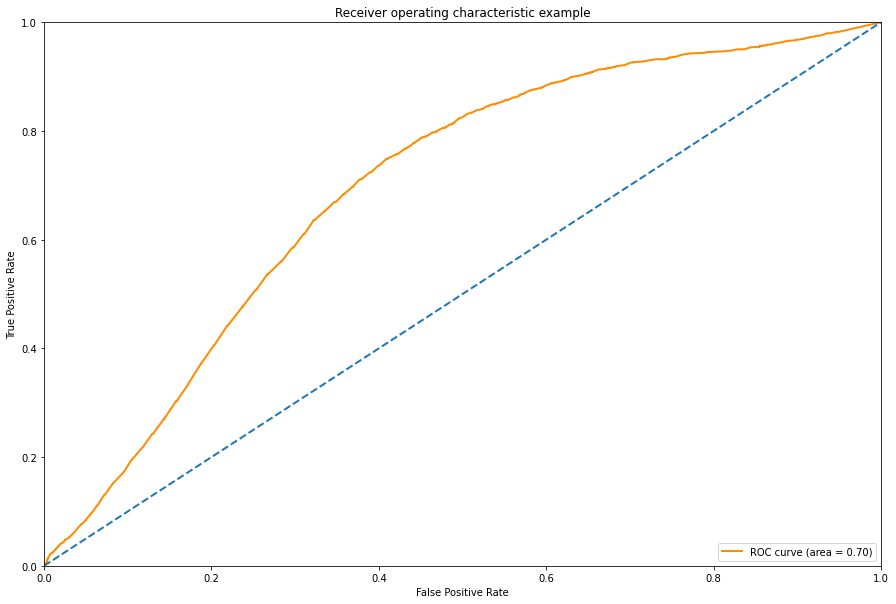

In [64]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()